# Part I

I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [485]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [12]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [21]:
dat[:,(0,2)]

array([[8.800e-03, 3.810e+02],
       [7.800e-03, 5.590e+02],
       [1.200e-03, 3.690e+02],
       ...,
       [9.876e-01, 2.631e+03],
       [3.060e-02, 7.050e+02],
       [8.898e-01, 1.044e+03]])

In [678]:
from sklearn.model_selection import train_test_split
# 85/15 split - creating a training data set of only (Xl, al) - no gamma
temp = train_test_split(np.log(dat[:,(0,2)]), test_size=0.15, random_state=42)

train_data = temp[0][:,0]
train_labs = temp[0][:,1]
test_data = temp[1][:,0]
test_labs = temp[1][:,1]

In [509]:
# get indices of ECDF sims using same test_train split seed
sims = pd.read_csv("traindata/sims-2021-08-16.csv.gz", compression='gzip', header=None)

In [16]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [91]:
intermediate_dim = 1024
latent_dim = 32
batch_size = 512
epsilon_std = 1.0
sigma2sq = np.sqrt(20.0).astype('float32')

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

# when z (i.e., \gamma) ~ N(\mu_2=0, \sigma_2) - can only do one latent dimension
# class KLDivergenceLayer(Layer):
#     """ Identity transform layer that adds KL divergence to the final model loss.
#     """
#     def __init__(self, *args, **kwargs):
#         self.is_placeholder = True
#         super(KLDivergenceLayer, self).__init__(*args, **kwargs)

#     def call(self, inputs):
#         mu, log_var = inputs
#         kl_batch = keras.backend.log(sigma2sq) - log_var + .5 * (keras.backend.exp(log_var) + keras.backend.square(mu))/sigma2sq - .5

#         self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
#         return inputs

# when z ~ N(0, 1) - but can do multiple dimensions i.e., MVN(0, I)
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 1 dim - Xl
x = keras.Input(shape=(1,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(512, activation='relu')(x)
h = Dense(256, activation='relu')(h)

gamma_mu = Dense(latent_dim)(h)
gamma_log_var = Dense(latent_dim)(h)

gamma_mu, gamma_log_var = KLDivergenceLayer()([gamma_mu, gamma_log_var])
gamma_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(gamma_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
gamma_eps = Multiply()([gamma_sigma, eps])
gamma = Add()([gamma_mu, gamma_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(256, input_dim=latent_dim, activation='relu'), 
    Dense(512, input_dim=256, activation='relu'),
    Dense(intermediate_dim, input_dim=512, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(gamma)
# symbolic representation
encoder = keras.Model(x, outputs=[gamma_mu, gamma_sigma])

In [92]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.................................................................

In [93]:
gamma_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(gamma_preds[0])))

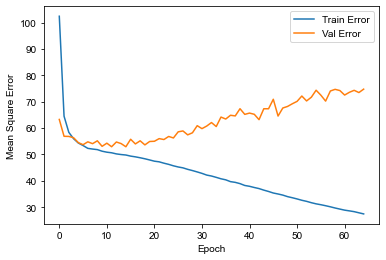

In [94]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

(array([[   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 2031., 5469.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 1499., 6001.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [1447.,  654.,  877.,  768.,  787.,  834.,  634.,  688.,  262.,
          549.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.

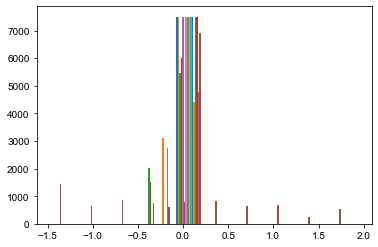

In [80]:
plt.hist(gamma_preds[0])

Text(40000, 2500, 'Intercept = 5488.94')

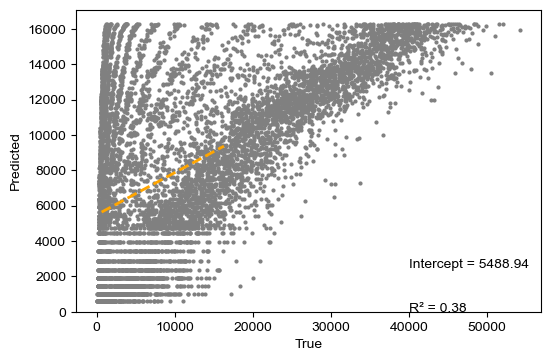

In [95]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
plt.ylim(0)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 10, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

# Part II

Below, I will ask the BaselineNet to learn the parameters of a $N(\mu, \sigma^2=0.25)$ since the $\log(a_l)$ is distributed normally, compared to the raw allele ages that are $\Gamma$ distributed. 

In [905]:
# gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]
# temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# # for each gamma value...
# Xltrain = []
# Xltest = []
# altrain = []
# altest = []
# for t in np.arange(len(temp)):
#     Xltrain.append(temp[t][0])
#     Xltest.append(temp[t][1])
#     altrain.append(temp[t][2])
#     altest.append(temp[t][3])

# train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
# train_labs = np.log(np.hstack(altrain[0:50]))

# test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
# test_labs = np.log(np.hstack(altest[0:50]))

# train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat[:,(0)]), dat[:,1])).T, np.log(dat[:,2]), test_size=0.15, random_state=42)

## only choose data that have negative gamma and choose few frequencies for testing
# dat_red = dat[dat[:,1]<0,:]
# # subsetting gamma=-100 and -0.1
# dat_red = np.vstack((dat_red[dat_red[:,1]==-100,:],dat_red[dat_red[:,1]==-1,:]))

train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat_red[:,0]), dat_red[:,1])).T, np.log(dat_red[:,2]), test_size=0.15, random_state=42)

(array([[  4.,   4.,   1.,   1.,   6.,   5.,   5.,  10.,  11.,  16.,  10.,
          12.,   7.,   4.,   1.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   2.,  10.,   9.,  10.,  13.,  14.,  13.,  19.,  14.,  39.,
          52.,  43.,  35.,  28.,   6.,   1.,   0.,   0.,   0.],
        [  0.,   0.,   3.,  10.,   5.,   7.,   7.,   9.,   4.,  11.,  11.,
          14.,  46.,  29.,  28.,  14.,   4.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   6.,   8.,  15.,   7.,   3.,   9.,   7.,   7.,
           7.,  11.,  31.,  55.,  19.,   7.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   5.,  14.,   9.,   7.,   6.,   6.,   6.,
           8.,   9.,  24.,  72.,  46.,  18.,   6.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   4.,   3.,   5.,  10.,   8.,   6.,   7.,
           2.,   7.,  14.,  40.,  54.,  18.,   6.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   6.,   2.,  10.,   6.,   8.,   8.,
          10.,  10.,   7.,  19.,  65.,  45.,   7.,   0.,   0.],
        [  0.,   0.,   0., 

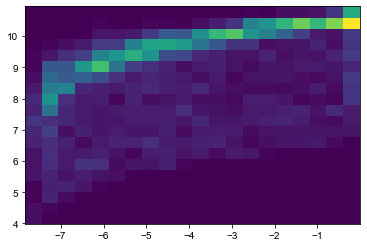

In [906]:
plt.hist2d(test_data[:,0], test_labs, [20,20])

In [923]:
sims.shape

(200, 50000)

In [925]:
sims_train, sims_test = train_test_split(sims.iloc[:,np.array(dat[:,1]<0)].T, test_size=0.15, random_state=42)

In [705]:
np.log(dat[:,1])

array([       nan,        nan,        nan, ..., 3.83764186, 4.22140605,
       4.60517019])

### Augmenting training data with more samples from the simulations

I will increase the size of the training data set by adding in 50 allele ages from the simulations to help with estimation of sd (i.e., each pair of $X_l,\gamma$ will have 50 samples of allele age). 

In [662]:
xlength = 25
for j in range(len(train_data)):
    train_data = np.append(train_data, np.repeat(dat[j,(0,1)],xlength).reshape(-1,2,order='F'), axis=0)
    train_labs = np.append(train_labs, np.log(sims_train.iloc[j,0:xlength]))

In [655]:
newtrain = np.append(train_data, np.repeat(dat[0,(0,1)],10).reshape(-1,2,order='F'), axis=0)

In [661]:
np.append(train_labs, np.log(sims_train.iloc[0,0:10]))

(42510,)

In [769]:
train_labs.shape

(1700,)

In [903]:
x = keras.Input(shape=(2,))
h = Dense(64, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(32, activation='relu', kernel_initializer='random_uniform')(h)
# h = Dense(32, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, kernel_initializer='random_uniform')(h)

## having just 1 free parameter works well...
# output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[:,0]), 0.15))(params)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(t[...,:1], tf.math.exp(0.5*t[...,1:])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

#param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [870]:
train_data

array([[-3.89222038, 14.67799   ],
       [-5.57275421, -0.4641589 ],
       [-4.29768549,  0.1467799 ],
       ...,
       [-0.52526267, -4.641589  ],
       [-7.4185809 , -2.154435  ],
       [-5.95224383, 21.54435   ]])

In [810]:
np.mean(test_labs)

7.8118608261946765

In [907]:
prob_model.fit(train_data, train_labs, batch_size=512, epochs=2, shuffle=True)

Epoch 1/2
42/42 [==============================] - 1s 1ms/step - loss: 19634.5681
Epoch 2/2
42/42 [==============================] - 0s 1ms/step - loss: 8255.6755


In [908]:
history = prob_model.fit(train_data, train_labs, epochs=5000, batch_size=1024, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................................................................................................
............

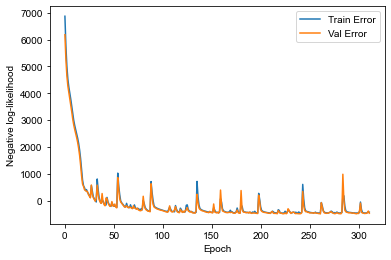

In [909]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [910]:
ahat = prob_model(test_data)
print(ahat.mean())
ahat.stddev()

tf.Tensor(
[[10.150786 ]
 [ 7.811357 ]
 [ 9.032258 ]
 ...
 [ 6.5931826]
 [ 7.2549553]
 [10.438525 ]], shape=(3750, 1), dtype=float32)


<tf.Tensor: shape=(3750, 1), dtype=float32, numpy=
array([[0.14932758],
       [0.7496764 ],
       [0.3541193 ],
       ...,
       [0.15214163],
       [0.07489275],
       [0.1117404 ]], dtype=float32)>

In [911]:
preds = np.exp(ahat.mean().numpy())
preds_sd = ahat.stddev().numpy()

(array([281.,   6.,   0.,   3.,   7.,   0.,   0.,   0.,   0.,   3.]),
 array([1.5029723e+01, 9.7225344e+05, 1.9444919e+06, 2.9167302e+06,
        3.8889685e+06, 4.8612070e+06, 5.8334455e+06, 6.8056840e+06,
        7.7779220e+06, 8.7501610e+06, 9.7223990e+06], dtype=float32),
 <BarContainer object of 10 artists>)

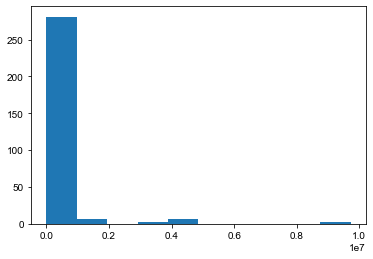

In [827]:
plt.hist(np.exp(pred_params[:,0]))

(array([158.,  13.,  16.,  19.,  22.,  19.,  16.,  15.,  13.,   9.]),
 array([   57. ,  4281.8,  8506.6, 12731.4, 16956.2, 21181. , 25405.8,
        29630.6, 33855.4, 38080.2, 42305. ]),
 <BarContainer object of 10 artists>)

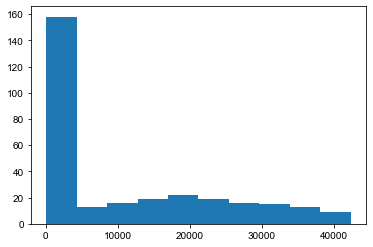

In [862]:
plt.hist(np.exp(np.ravel(test_labs)))

Text(40000, 2500, 'Intercept = 416.45')

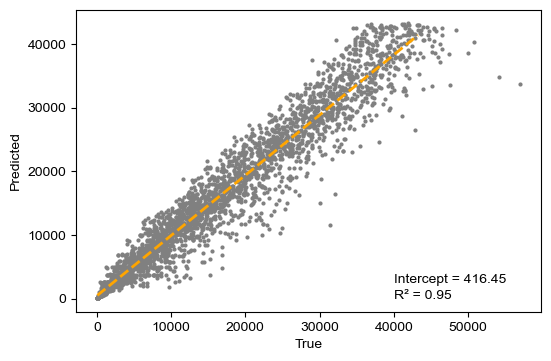

In [912]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [913]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = np.exp(np.log(preds[i]) - 1.96*preds_sd[i]), np.exp(np.log(preds[i]) + 1.96*preds_sd[i])
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

Accuracy: 95.65%


(array([  64.,  170.,  284.,  401.,  473.,  642.,  907., 1082., 1375.,
        2102.]),
 array([ 4.3430862,  4.9865456,  5.630005 ,  6.2734647,  6.916924 ,
         7.5603833,  8.203843 ,  8.847302 ,  9.490762 , 10.134221 ,
        10.77768  ], dtype=float32),
 <BarContainer object of 10 artists>)

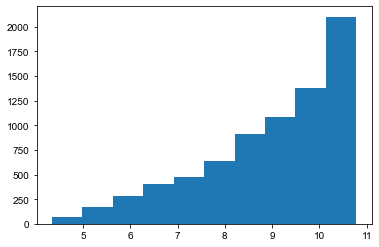

In [311]:
plt.hist(pred_params[:,1])

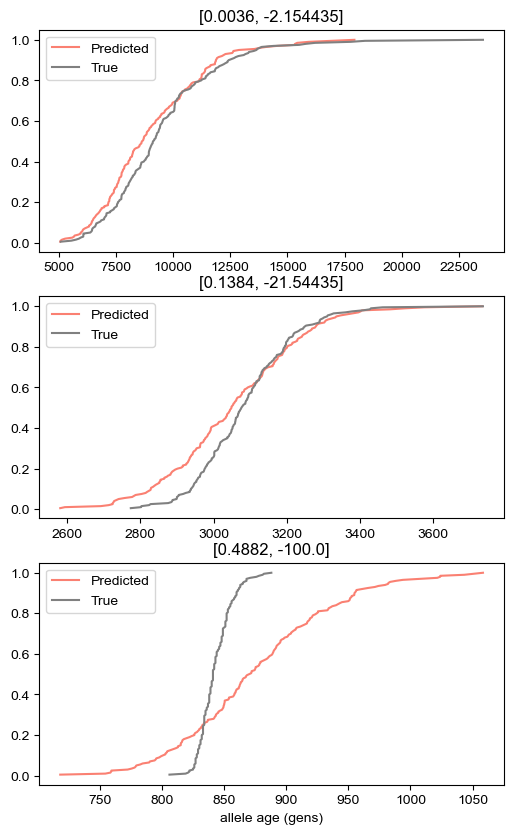

In [950]:
## compare ECDFs of the true allele ages and estimated distributions (3 examples)
# find that SD=0.1 is not great for all allele ages (as expected...)
plt.figure(dpi=100, figsize=(6,10))
plt.subplot(311)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[789,0]),preds_sd[789],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[789,0]), test_data[789,1]])
e2 = ECDF(sims_test.iloc[789,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(312)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[49,0]),preds_sd[49],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[49,0]), test_data[49,1]])
e2 = ECDF(sims_test.iloc[49,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(313)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[1098,0]),preds_sd[1098],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[1098,0]), test_data[1098,1]])
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[1098,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

In [949]:
np.where(np.logical_and(test_data[:,0]>-1, test_data[:,1]==-100))

(array([ 249,  767,  901, 1018, 1098, 1334, 1518, 1605, 1886, 1912, 1972,
        2378, 2612, 3171, 3328]),)

In [965]:
kst = np.empty((len(test_labs),2))
for i in range(len(test_labs)):
    kst[i,:] = scipy.stats.kstest(np.exp(np.random.normal(np.log(preds[i]),preds_sd[i],200)),sims_test.iloc[i,:])

450 more pairs have significant differences with sd=0.25 when compared to sd=0.1 (best in test, increases again drastically for sd=0.05 and a little bit for sd=0.15) 


But decreasing the sd we see that a smaller percentage of 'true' values fall within the 95% CI of the estimate...seems like there is a balance at sd=0.15   

Again lowest accuracy when $|\gamma| < 0.02$ and $X_l < 5 \times 10^{-4}$ 

In [885]:
len(np.where(kst[:,1]<0.05)[0])

3120

In [963]:
np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.25))[0]

array([   0,    2,    3, ..., 7489, 7494, 7498])

Text(0.5, 1.0, 'KS-test value > 0.25')

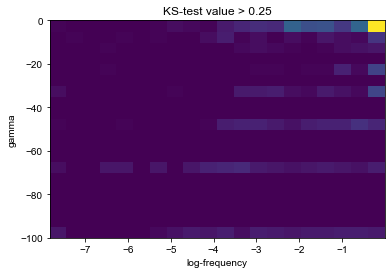

In [977]:
# query indices with highest kst (ONLY significant values)
kst_sig = np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.25))[0]
h_kst = plt.hist2d(test_data[kst_sig,0],test_data[kst_sig,1], [20,20])
plt.ylim((-100,0))
plt.xlabel('log-frequency')
plt.ylabel('gamma')
plt.title('KS-test value > 0.25')

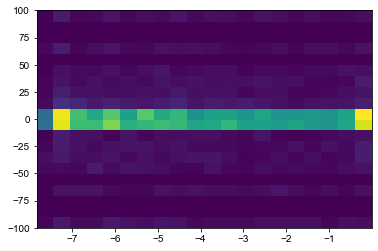

In [902]:
h_full = plt.hist2d(test_data[:,0],test_data[:,1], [20,20])
plt.title('Number of data points in each bin')
plt.xlabel('log-frequency')
plt.ylabel('gamma')

In [502]:
scipy.stats.kstest(np.random.normal(pred_params[57,0],0.25,200),np.random.normal(pred_params[55,0],0.25,200))

0.205

In [473]:
np.linspace(0,1,200)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

# Part III

Below, I will model the allele ages as coming from a $\Gamma(\alpha, \beta) = x^{\alpha - 1} e^{-x \beta} \beta^{\alpha}/ \Gamma(\alpha)$ distribution given $X_l$ and $\gamma$. The loss function needs to be defined as a negative log-likelihood of the $\Gamma$ distribution...

In [978]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs =np.hstack(altrain[0:50])

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

(array([1.6203e+04, 6.8680e+03, 5.2150e+03, 4.2460e+03, 3.6850e+03,
        3.2470e+03, 2.3710e+03, 5.9200e+02, 6.5000e+01, 8.0000e+00]),
 array([5.40000e+01, 6.01670e+03, 1.19794e+04, 1.79421e+04, 2.39048e+04,
        2.98675e+04, 3.58302e+04, 4.17929e+04, 4.77556e+04, 5.37183e+04,
        5.96810e+04]),
 <BarContainer object of 10 artists>)

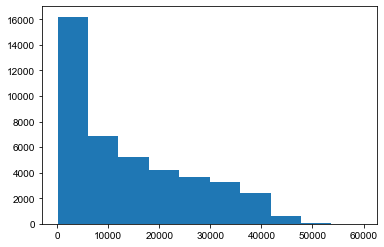

In [980]:
plt.hist(train_labs)

In [993]:
x = keras.Input(shape=(2,))
h = Dense(500, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(250, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(100, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, kernel_initializer='random_uniform')(h)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(tf.math.exp(t[...,:1]), tf.math.exp(t[...,1:])))(params)
#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[:,0]), 1e-3+tf.math.softplus(0.05*t[:,1])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [990]:
train_data.shape

(42500, 2)

In [997]:
history = prob_model.fit(train_data, train_labs, epochs=500, batch_size=1024, verbose=0, validation_split=0.1, shuffle=True, callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

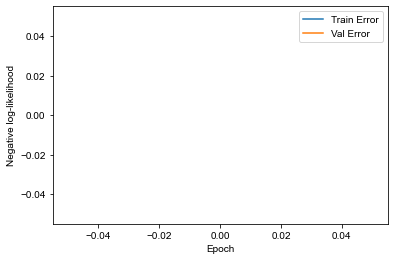

In [998]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [999]:
param_model = keras.Model(x, params)
params = param_model(test_data)
preds_co = np.exp(params[:,0].numpy())
preds_ra = np.exp(params[:,1].numpy())

In [1003]:
params

<tf.Tensor: shape=(7500, 2), dtype=float32, numpy=
array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)>

Text(40000, 2500, 'Intercept = 1163.16')

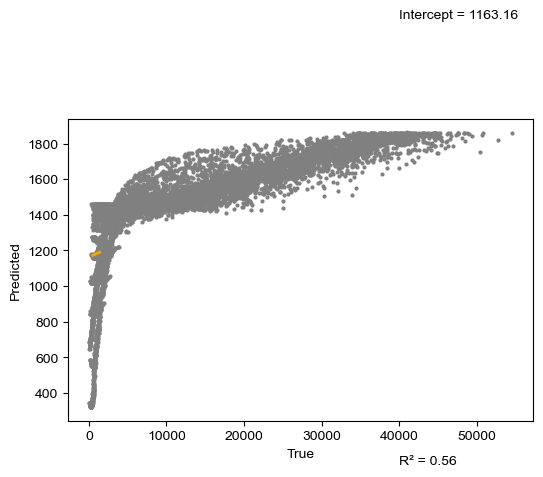

In [442]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(test_labs, pred_params[:,0], 'o', color='grey', markersize=2)
res = sm.OLS(pred_params[:,0], sm.add_constant(test_labs)).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(pred_params[:,0]), np.max(pred_params[:,0]), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))